In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# get model
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
#model.summary()

553467904/553467096 [==============================] - 5s 0us/step


(1, 600, 1500, 3)
(1, 1200, 3000, 3)


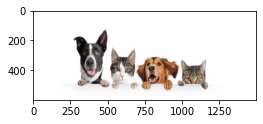

In [3]:
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/gdrive/My Drive/data/template-matching/'
height = 600
width  = 1500
image_path = PATH+'image7.jpg'

scale_level = 2
list_of_images = []

for i in range(scale_level):
  img = kimage.load_img(image_path, target_size=(height*(i+1), width*(i+1)))
  img = np.expand_dims(img, axis=0)
  list_of_images.append(img)

# check
for i in range(scale_level):
  print(list_of_images[i].shape)

plt.figure(figsize=(4,4))
plt.imshow(list_of_images[0][0])

In [4]:
# check model
for i in range(19,23):
  print(model.layers[i].name)

flatten
fc1
fc2
predictions


In [5]:
def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

In [6]:
def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

In [7]:
# compute features for templates
list_of_features = []
for i in range(scale_level):
  features = preprocess_input(list_of_images[i])
  print(features.shape)
  features = compute_features(features)
  list_of_features.append(features)

(1, 600, 1500, 3)
(1, 1200, 3000, 3)


In [8]:
# check
for i in range(scale_level):
  print(list_of_features[i].shape)

(1, 18, 46, 512)
(1, 37, 93, 512)


In [9]:
# compute predictions
side = 7
prediction_data = []

for scale in range(scale_level):
  print('scale: ', scale)
  height_fm = list_of_features[scale].shape[1]
  width_fm  = list_of_features[scale].shape[2]
  depth_fm  = list_of_features[scale].shape[3]

  for i in range(height_fm-side+1):
    for j in range(width_fm-side+1):
      patch = list_of_features[scale][:,i:i+side,j:j+side,:]
      patch = compute_prediction(patch)
      prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), 
                               i, j, tf.math.argmax(patch[0]).numpy(), scale) )
      
print(len(prediction_data))

scale:  0
scale:  1
3177


In [10]:
def getKey(item):
    return item[0]

pred_sorted = sorted(prediction_data, key=getKey, reverse=True)
print(pred_sorted[:3])

[(0.95744056, 22, 39, 283, 1), (0.9384233, 23, 39, 283, 1), (0.9351347, 24, 38, 283, 1)]


In [11]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


In [12]:
from scipy.spatial import distance
a = (1, 2)
b = (4, 5)
dst = distance.euclidean(a, b)
print(dst)

4.242640687119285


In [13]:
def check_duplication(i,j,data):
  result = False

  coord1 = (i,j)
  
  length = len(data)
  for k in range(length):
    coord2 = (data[k][1], data[k][2])
    dst = distance.euclidean(coord1, coord2)

    if (dst < 5):
      result = True
      break
  
  return result

In [14]:
from scipy.spatial import distance

# remove duplication
def remove_duplication(data):
  result = []

  length = len(data)
  for k in range(length-1):
    duplicated = check_duplication(data[k][1], data[k][2], result)
    
    if (duplicated==False and data[k][0]>0.5):
      result.append( data[k] )
    
    
  return result

In [15]:
print(len(pred_sorted))
print(pred_sorted[:3])

result = remove_duplication(pred_sorted)
print(len(result))
print(result[:3])

3177
[(0.95744056, 22, 39, 283, 1), (0.9384233, 23, 39, 283, 1), (0.9351347, 24, 38, 283, 1)]
21
[(0.95744056, 22, 39, 283, 1), (0.8178092, 25, 63, 281, 1), (0.8138674, 27, 31, 283, 1)]


In [16]:
result

[(0.95744056, 22, 39, 283, 1),
 (0.8178092, 25, 63, 281, 1),
 (0.8138674, 27, 31, 283, 1),
 (0.80608755, 11, 22, 207, 0),
 (0.7989629, 28, 54, 568, 1),
 (0.7983379, 25, 50, 207, 1),
 (0.76992136, 6, 10, 227, 0),
 (0.766482, 10, 16, 268, 1),
 (0.7641215, 1, 9, 195, 0),
 (0.738926, 17, 33, 281, 1),
 (0.7181673, 21, 68, 285, 1),
 (0.7120905, 17, 43, 157, 1),
 (0.6906255, 30, 45, 568, 1),
 (0.6420605, 22, 30, 281, 1),
 (0.6302975, 6, 5, 180, 0),
 (0.6268202, 27, 36, 283, 1),
 (0.6000203, 26, 68, 281, 1),
 (0.5580739, 21, 16, 247, 1),
 (0.54808897, 14, 26, 227, 1),
 (0.546997, 17, 38, 281, 1),
 (0.50328815, 18, 52, 231, 1)]

0.95744056 22 39 1
0.8178092 25 63 1
0.8138674 27 31 1
0.80608755 11 22 0
0.7989629 28 54 1
0.7983379 25 50 1
0.76992136 6 10 0
0.766482 10 16 1
0.7641215 1 9 0


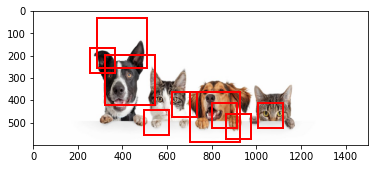

In [24]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
for i in range(length):
  if (result[i][0] > 0.76 and result[i][4]==0):
    scale_height = height//18
    scale_width  = width//46

    print(result[i][0], result[i][1], result[i][2], result[i][4])
    rect = patches.Rectangle((result[i][2]*scale_width // (result[i][4]+1),
                              result[i][1]*scale_height // (result[i][4]+1)), 
                             224 // (result[i][4]+1), 
                             224 // (result[i][4]+1), 
                             linewidth=2, edgecolor='r', 
                             facecolor='none')
    ax.add_patch(rect)
    #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()

0.95744056 22 39 1
0.8178092 25 63 1
0.8138674 27 31 1
0.7989629 28 54 1
0.7983379 25 50 1
0.766482 10 16 1


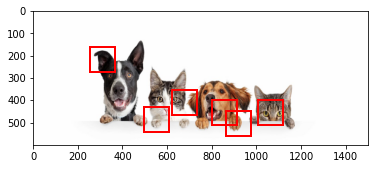

In [21]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))
scale_height = height//37
scale_width  = width//93

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
for i in range(length):
  if (result[i][0] > 0.76 and result[i][4]==1):    
    print(result[i][0], result[i][1], result[i][2], result[i][4])
    rect = patches.Rectangle(( (result[i][2]) *scale_width,
                               (result[i][1]) *scale_height), 
                              224//2, 
                              224//2, 
                              linewidth=2, edgecolor='r', 
                              facecolor='none')
    ax.add_patch(rect)
    #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()